In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Some functions created for graphing & data manipulation
from clean_functions import convertAge, convertSalary, convertChildren, childrenOrNotInUniverse, bar_charts, dataPrep

# To use SQL functionality
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

## Reading In Data

In [2]:
# Setting header to none, as there are no column titles
train_data = pd.read_csv('./census_income_learn.csv', header=None)
train_data['source'] = 'train'

test_data = pd.read_csv('./census_income_test.csv', header=None)
test_data['source'] = 'test'

data = pd.concat([train_data, test_data])

In [4]:
duplicate_no = len(data) - len(data.drop_duplicates())
print('potential duplicates:', duplicate_no)

# with no unique ID its hard to tell if people are being counted twice. 
# Model gave higher test scores without dropping
# data = data.drop_duplicates()

potential duplicates: 4112


In [5]:
# Confusion over number of variables and names, comparing unique values to last section of metadata
for i in range(42):
    print('Column', i)
    print(data[i].unique())
    print('')

Column 0
[73 58 18  9 10 48 42 28 47 34  8 32 51 46 26 13 39 16 35 12 27 56 55  2
  1 37  4 63 25 81 11 30  7 66 84 52  5 36 72 61 41 90 49  6  0 33 57 50
 24 17 53 40 54 22 29 85 38 76 21 31 74 19 15  3 43 68 71 45 62 23 69 75
 44 59 60 64 65 70 67 78 20 14 83 86 89 77 79 82 80 87 88]

Column 1
[' Not in universe' ' Self-employed-not incorporated' ' Private'
 ' Local government' ' Federal government' ' Self-employed-incorporated'
 ' State government' ' Never worked' ' Without pay']

Column 2
[ 0  4 40 34 43 37 24 39 12 35 45  3 19 29 32 48 33 23 44 36 31 30 41  5
 11  9 42  6 18 50  2  1 26 47 16 14 22 17  7  8 25 46 27 15 13 49 38 21
 28 20 51 10]

Column 3
[ 0 34 10  3 40 26 37 31 12 36 41 22  2 35 25 23 42  8 19 29 27 16 33 13
 18  9 17 39 32 11 30 38 20  7 21 44 24 43 28  4  1  6 45 14  5 15 46]

Column 4
[' High school graduate' ' Some college but no degree' ' 10th grade'
 ' Children' ' Bachelors degree(BA AB BS)'
 ' Masters degree(MA MS MEng MEd MSW MBA)' ' Less than 1st grade'


[' Not in universe' ' No' ' Yes']

Column 38
[2 0 1]

Column 39
[ 0 52 30 49 32 15 38 48  9 24 50 10 45 43  4 26 40 20  6 12 51  1  8 39
 13 16 34 14 36 44 22 41 46 28 23 35 25 17 11 37  5 42 29  2 21 19 47  3
 27  7 18 33 31]

Column 40
[95 94]

Column 41
[' - 50000.' ' 50000+.']



In [6]:
# Creating column names and assigning to train and test df
headers = ['Age', 'Class of Worker', 'detailed industry recode', 'detailed occupation recode',
          'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat',
          'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex',
          'member of a labor union', 'reason for unemployment', 'full or part time employment stat',
          'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 
          'region of previous residence', 'state of previous residence',
          'detailed household and family stat', 'detailed household summary in household',
          'instance weight', 'migration code-change in msa', 'migration code-move within reg',
          'migration code-change in reg', 'live in this house 1 year ago',
          'migration prev res in sunbelt', 'num persons worked for employer',
          'family members under 18', 'country of birth father', 'country of birth mother',
          'country of birth self', 'citizenship', 'own business or self employed',
          'fill inc questionnaire for veterans admin', 'veterans benefits', 'weeks worked in year',
          'year', 'salary', 'source']

print(len(headers))
data.columns = headers

43


## Exploratory Analysis

In [7]:
# looking at value counts to get better idea of how missing data is handled
for i in headers:
    print(i)
    print(data[i].value_counts())
    print('')

Age
34    5210
35    5120
33    5090
4     5001
5     4974
      ... 
85     639
86     510
87     456
88     382
89     304
Name: Age, Length: 91, dtype: int64

Class of Worker
 Not in universe                   150324
 Private                           108099
 Self-employed-not incorporated     12725
 Local government                   11617
 State government                    6394
 Self-employed-incorporated          4913
 Federal government                  4330
 Never worked                         643
 Without pay                          240
Name: Class of Worker, dtype: int64

detailed industry recode
0     150967
33     25782
43     12510
4       9051
42      6987
45      6686
29      6420
37      6161
41      5815
32      5418
35      5045
39      4393
34      4119
44      3771
2       3273
11      2667
50      2525
38      2475
40      2472
47      2448
24      2234
19      2067
12      2030
30      1776
31      1748
25      1567
9       1483
36      1440
22      1421
13   

 Householder                             113418
 Child under 18 never married             75465
 Spouse of householder                    62366
 Child 18 or older                        21769
 Other relative of householder            14533
 Nonrelative of householder               11478
 Group Quarters- Secondary individual       187
 Child under 18 ever married                 69
Name: detailed household summary in household, dtype: int64

instance weight
707.90     53
753.23     46
1362.16    43
1191.21    43
1787.34    41
           ..
503.22      1
635.76      1
1387.37     1
1982.20     1
3047.28     1
Name: instance weight, Length: 123232, dtype: int64

migration code-change in msa
 ?                   149642
 Nonmover            123937
 MSA to MSA           15890
 NonMSA to nonMSA      4155
 Not in universe       2239
 MSA to nonMSA         1154
 NonMSA to MSA          910
 Not identifiable       630
 Abroad to MSA          619
 Abroad to nonMSA       109
Name: migration code-ch

In [8]:
# Converting All Children or Not in universe values to NaN and banding age groups
data_2 = data.copy()
data_2['education'] = data_2['education'].apply(lambda x: convertChildren(x))
data_2['Age'] = data_2['Age'].apply(lambda x: convertAge(x))
data_2['salary'] = data_2['salary'].apply(lambda x: convertSalary(x))
data_2 = data_2.applymap(lambda x: childrenOrNotInUniverse(x))
data_2 = data_2.dropna(subset = ["education"])
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176230 entries, 0 to 99760
Data columns (total 43 columns):
Age                                          176230 non-null object
Class of Worker                              128268 non-null object
detailed industry recode                     176230 non-null int64
detailed occupation recode                   176230 non-null int64
education                                    176230 non-null object
wage per hour                                176230 non-null int64
enroll in edu inst last wk                   9388 non-null object
marital stat                                 176230 non-null object
major industry code                          128090 non-null object
major occupation code                        128090 non-null object
race                                         176230 non-null object
hispanic origin                              176230 non-null object
sex                                          176230 non-null object
member of a

Age


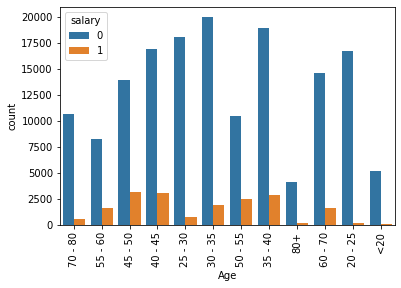


Class of Worker


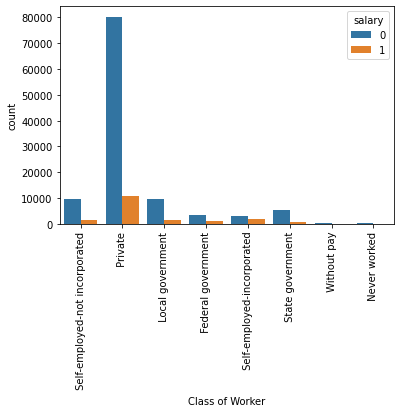


education


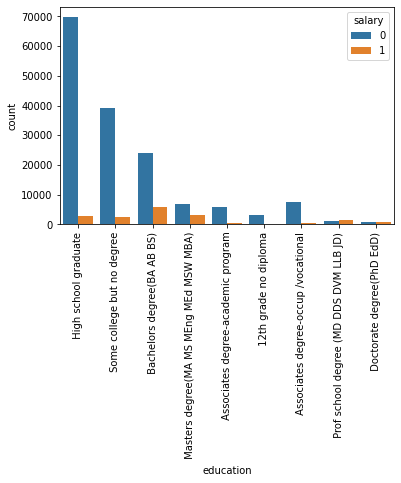


marital stat


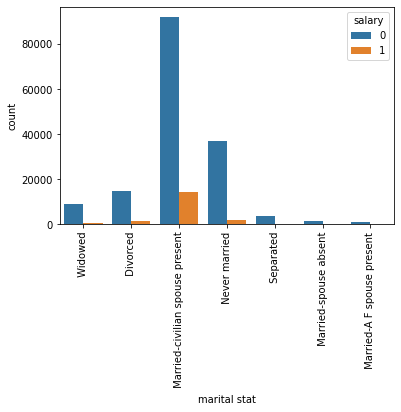


race


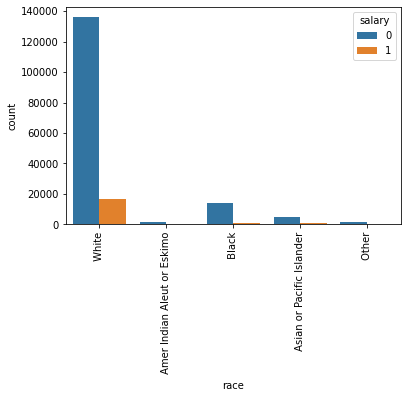


sex


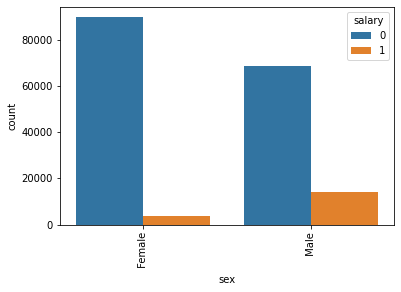


full or part time employment stat


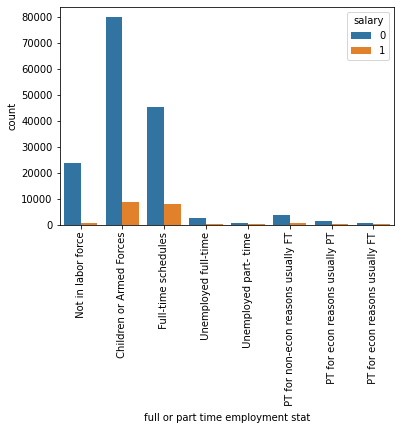


num persons worked for employer


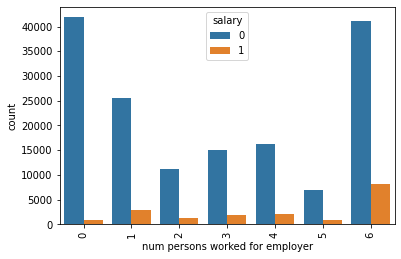


country of birth self


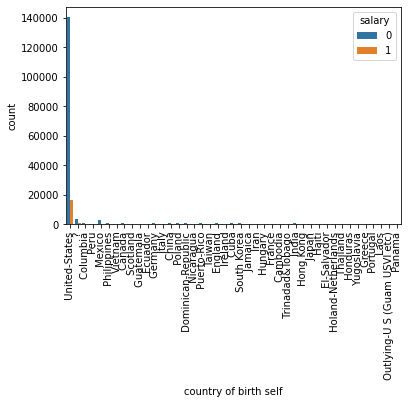


citizenship


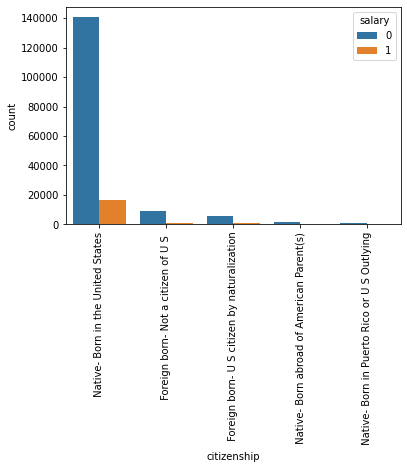


own business or self employed


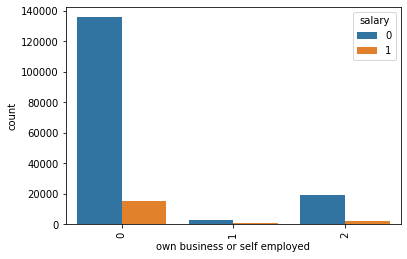


major industry code


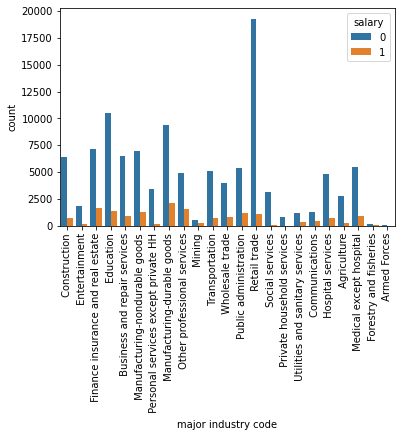


major occupation code


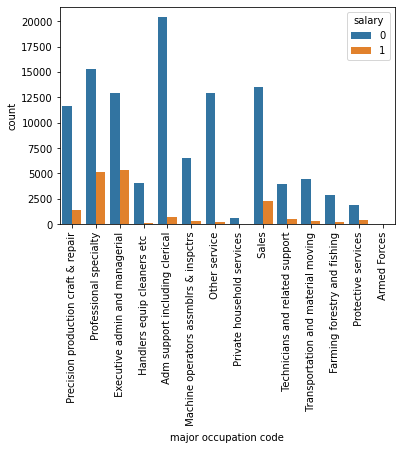

In [9]:
# Variables which didn't have a significant portion missing, and made sense in predicting salary
categoric = ['Age', 'Class of Worker', 'education', 'marital stat', 'race', 'sex',
            'full or part time employment stat', 'num persons worked for employer',
            'country of birth self', 'citizenship', 'own business or self employed',
            'major industry code', 'major occupation code']

for i in categoric:
    print(i)
    bar_charts(i, data=data_2, hue="salary")
    print('')
    
# Thought it was weird that employment stat had a value "children or armed forces" 
# but i've excluded children so it should just be armed forces

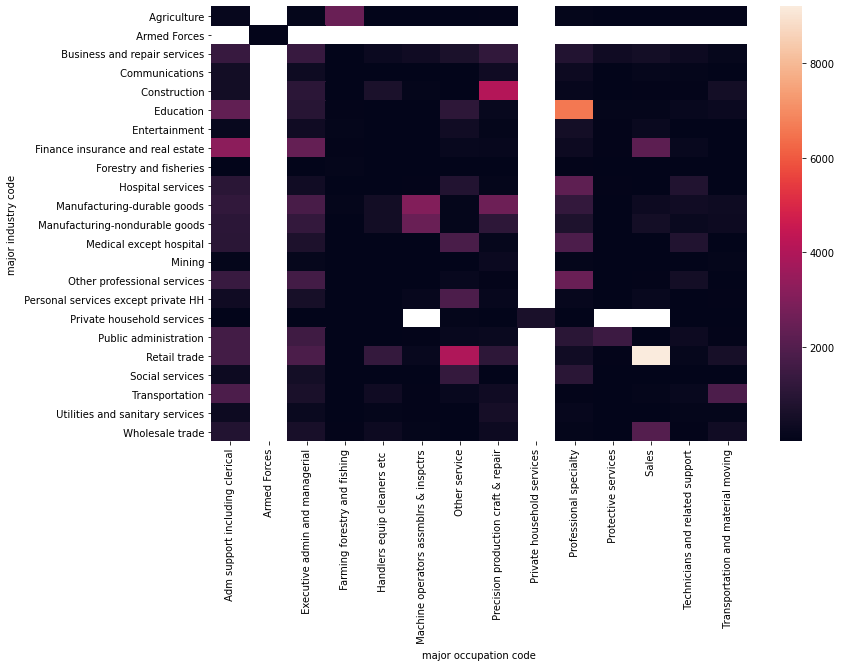

In [10]:
# Checking correlation between occupation and industry
q = """
SELECT 
"major industry code",
"major occupation code",
count(*) as count
FROM
data_2
GROUP BY 1,2
"""

test_corr = pysqldf(q).dropna()
test_corr = test_corr.pivot(index="major industry code", 
                            columns="major occupation code", 
                            values="count")

plt.figure(figsize=(12,8))
ax = sns.heatmap(test_corr)
plt.show()

# I'm not worried about measuring the same thing twice here, most of the occupations have a mixture of industries

## Data Modelling
#### Logistic Regression & Random Forest Approach

In [11]:
# Handling Class Imbalance - Upsampling needed for over $50,000 group
print('salary over $50,000:')
print(data_2.salary.value_counts())
print('')

salary over $50,000:
0    158101
1     18129
Name: salary, dtype: int64



In [19]:
model_variables = ['Age', 
                  'Class of Worker', 
                  'education', 
                  'marital stat', 
                  'race', 
                  'sex',
                  'full or part time employment stat', 
                  'num persons worked for employer',
                  'own business or self employed', 
                  'major industry code', 
                  'major occupation code', 
                  'salary', 
                  'source',
#                   'hispanic origin'
                  'tax filer stat'
                  ]
   

## Logistic Regression

In [20]:
print("Logistic Regression w/o upsample")
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, 
                                                          model_variables, 
                                                          upsample=False,
                                                          scale=False)

lr = LogisticRegression(max_iter=10000).fit(train_x, train_y)
pred_y = lr.predict(test_x)
print('accuracy:', accuracy_score(test_y, pred_y))
print('recall:', recall_score(test_y, pred_y))
print('')

print("Logistic Regression with upsample and base values")
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, 
                                                          model_variables, 
                                                          drop_first=True,
                                                          scale=False)

lr = LogisticRegression(max_iter=10000).fit(train_x, train_y)
pred_y = lr.predict(test_x)
print('accuracy:', accuracy_score(test_y, pred_y))
print('recall:', recall_score(test_y, pred_y))
print('')

print("Logistic Regression with upsample")
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, 
                                                          model_variables,
                                                          scale=True)

lr = LogisticRegression(max_iter=10000).fit(train_x, train_y)
pred_y = lr.predict(test_x)
print('accuracy:', accuracy_score(test_y, pred_y))
print('recall:', recall_score(test_y, pred_y))

Logistic Regression w/o upsample
accuracy: 0.915033904658057
recall: 0.3316182572614108

Logistic Regression with upsample and base values
accuracy: 0.8106090149043629
recall: 0.8264656552565374

Logistic Regression with upsample
accuracy: 0.8109324024843775
recall: 0.8272470839368758


In [21]:
coeffs = pd.DataFrame(list(zip(column_names, lr.coef_[0])), 
                      columns=['var','coeff'])

print('highest positive coefficients')
print(coeffs.sort_values(by='coeff',ascending=False).head(15))
print('')

print('lowest negative coefficients')
print(coeffs.sort_values(by='coeff',ascending=False).tail(15))
print('')

highest positive coefficients
                                                  var     coeff
0                     num persons worked for employer  0.449490
78  major occupation code_ Executive admin and man...  0.373168
29  education_ Prof school degree (MD DDS DVM LLB JD)  0.359750
18        Class of Worker_ Self-employed-incorporated  0.323143
44                                          sex_ Male  0.316398
26               education_ Doctorate degree(PhD EdD)  0.313941
28  education_ Masters degree(MA MS MEng MEd MSW MBA)  0.307953
85      major occupation code_ Professional specialty  0.272357
93                tax filer stat_ Joint both under 65  0.233976
87                       major occupation code_ Sales  0.219827
8                                         Age_50 - 55  0.178552
63   major industry code_ Manufacturing-durable goods  0.175600
25              education_ Bachelors degree(BA AB BS)  0.168559
19    Class of Worker_ Self-employed-not incorporated  0.156010
37        

## Random Forest

In [22]:
# I struggled to get this model outperforming Logistic Regression by any more than a fraction of a %
print("Random Forest with base classes")
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, model_variables, drop_first=True)

rf = RandomForestClassifier(max_depth=12, 
                            max_features=0.2, 
                            min_samples_leaf=15,
                            random_state=242).fit(train_x, train_y)
pred_y = rf.predict(test_x)
print('accuracy:', accuracy_score(test_y, pred_y))
print('recall:', recall_score(test_y, pred_y))
print('')

print("Random Forest with no base classes")
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, model_variables)

rf = RandomForestClassifier(max_depth=12, 
                            max_features=0.2, 
                            min_samples_leaf=15,
                            random_state=242).fit(train_x, train_y)
pred_y = rf.predict(test_x)
print('accuracy:', accuracy_score(test_y, pred_y))
print('recall:', recall_score(test_y, pred_y))
print('')

Random Forest with base classes
accuracy: 0.8028952699810723
recall: 0.8153160021346344

Random Forest with no base classes
accuracy: 0.805891360795914
recall: 0.8285621712281772

